In [1]:
from sys import exit
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, ReLU, ELU
from tensorflow.keras.models import Model
from matplotlib import pyplot as plt
# Для очистки области вывода в IPython, Jupyter, Colab
from IPython import display
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.utils import normalize, to_categorical
import tensorflow as tf

In [2]:
def one_part(units, x):
    x = Dense(units)(x)
    x = LeakyReLU()(x)
    #x = ReLU()(x)
    return Dropout(0.25)(x)

In [3]:
# model.summary()
def some_plts(imgs):
    fig, axs = plt.subplots(4, 4)
    k = -1
    for i in range(4):
        for j in range(4):
            k += 1
            img = imgs[k].reshape(28, 28)
            axs[i, j].imshow(img, cmap = 'gray')
            axs[i, j].axis('off')
    plt.subplots_adjust(wspace = 1, hspace = 0)
    plt.show()

In [4]:
(x_trn, y_trn), (x_tst, y_tst) = mnist.load_data()
print(x_trn.shape)
x_trn = x_trn.reshape(x_trn.shape[0], 28, 28, 1)
print(x_trn.shape)

(60000, 28, 28)
(60000, 28, 28, 1)


In [5]:
# Все параметры имеют заданные по умолчанию значения
#datagen = ImageDataGenerator(samplewise_center=True, data_format='channels_last')
datagen = ImageDataGenerator(featurewise_center=True, data_format='channels_last')
#datagen = ImageDataGenerator(zca_whitening=True, data_format='channels_last')
print('Настройка генератора...')
datagen.fit(x_trn)
X_y = datagen.flow(x_trn, y_trn, batch_size = len(y_trn), shuffle=False) # batch_size = 32
dset = X_y[0][0][:].astype('uint8')
#dset -= np.min(dset)

Настройка генератора...


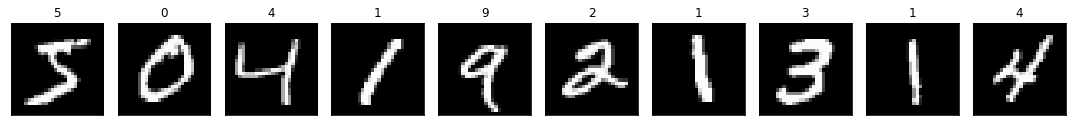

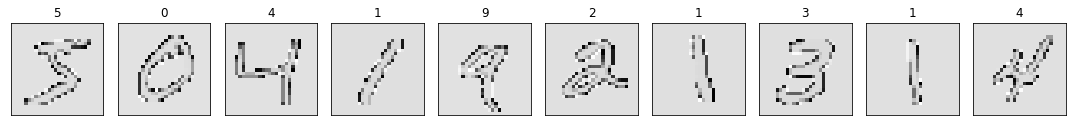

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axs.flat):
	ax.imshow(x_trn[i], cmap='gray')
	ax.set_title(chr(y_trn[i] + 48))
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axs.flat):
	ax.imshow(dset[i], cmap='gray')
	ax.set_title(chr(y_trn[i] + 48))
plt.tight_layout()
plt.show()

In [7]:
latent_size = 10 # Размер латентного пространста
inp = Input(shape = (784))
x = one_part(512, inp)
x = one_part(256, inp)
x = one_part(128, x)
x = one_part(64, x)
x = Dense(latent_size)(x)
encoded = LeakyReLU()(x)
x = one_part(64, encoded)
x = one_part(128, x)
x = one_part(256, x)
x = one_part(512, x)
decoded = Dense(784, activation = 'sigmoid')(x)
model = Model(inputs = inp, outputs = decoded)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss = tf.keras.losses.CosineSimilarity(), metrics=['accuracy']) # nadam

In [8]:
print(np.min(dset), "\t", np.max(dset))
ds = dset.reshape(-1, 784) / 255.0
print(np.min(ds), "\t", np.max(ds))

print(np.min(x_trn), "\t",np.max(x_trn))
xt = x_trn.reshape(-1, 784) / 255.0
print(np.min(xt), "\t",np.max(xt))

0 	 255
0.0 	 1.0
0 	 255
0.0 	 1.0


In [9]:
history = model.fit(xt, ds, epochs=40, batch_size=8192)
tf.keras.backend.clear_session()
display.clear_output()

In [17]:
x_test = x_tst.reshape(x_tst.shape[0], 28, 28, 1)
testGen = ImageDataGenerator(featurewise_center=True, data_format='channels_last')
testGen.fit(x_test)
test_generated = datagen.flow(x_test, y_tst, batch_size = len(y_tst), shuffle=False) # batch_size = 32
test_generated = test_generated[0][0][:].astype('uint8')
test_generated = test_generated.reshape(-1, 784) / 255.0

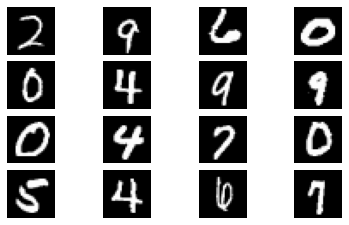

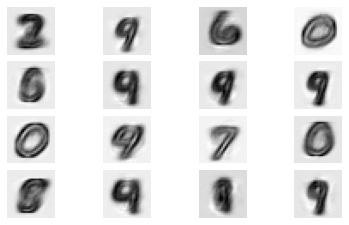

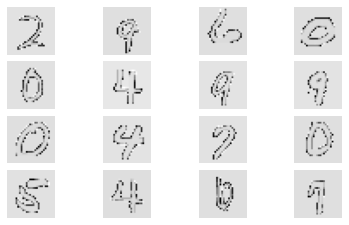

In [18]:

arr_idx = np.random.randint(0, len(y_tst), 16)

imgs_for_test = (x_tst.reshape(-1, 784) / 255.0) [arr_idx]

some_plts(imgs_for_test)
imgs_pedicted = model.predict(imgs_for_test)

some_plts(imgs_pedicted) # imgs_pedicted.shape = (16, 784)

ds_for_test = test_generated[arr_idx]

some_plts(ds_for_test)
# Прогноз из шума
#img = np.random.uniform(0, 1, 16 * 784).reshape(16, 784)
#imgs_pedicted = model.predict(img)
#some_plts(imgs_pedicted)

In [11]:
print(history.history['loss'][-1])
print(history.history['accuracy'][-1])
print(model.summary())

-0.9869093894958496
4.999999873689376e-05
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)